In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns
import albumentations as A

## Load DataFrame with Pathing

In [3]:
df = pd.read_csv('data/POC_imagedata.csv')

In [4]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [5]:
#df = df.sample(1000)

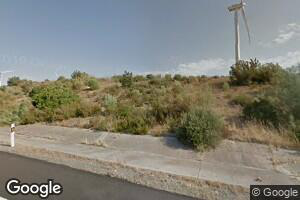

In [6]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [7]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [8]:
train.shape

(2400, 5)

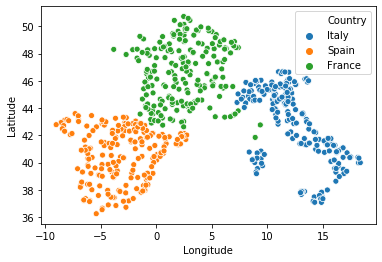

In [9]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [10]:
MAPPING = {'Spain': 0, # Spain
           'France': 1, # France
           'Italy': 2} # Italy

In [11]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [12]:
def individ_panos(path):
    return [img_to_np(path + direction + '.jpg') for direction in 'NESW']

In [13]:
def get_xy(path, y_map):
    x = individ_panos(path)
    y = y_map[path[12: 12 + path[12:].find('/')]]
    return x, y

In [14]:
x, y = get_xy(train.Path.iloc[0], MAPPING)

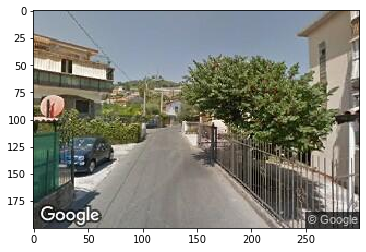

In [15]:
plt.imshow(x[0])

In [16]:
len(x), y

(4, 2)

In [17]:
x[0].shape

(200, 300, 3)

#### Data Augmentation Functions

In [18]:
transforms = A.Compose([
        A.RandomCrop(height=150, width=250),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.15),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=22.5, p=0.25),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize()
    ])

no_transforms = A.Compose([
        A.CenterCrop(height=150, width=250),
        A.Normalize()
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 250, 3)


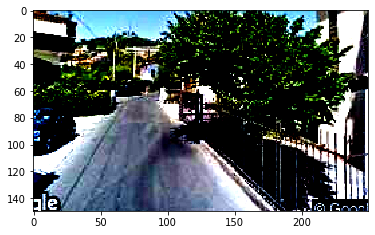

In [19]:
aug = transforms(image=x[0])['image']
print(aug.shape)
plt.imshow(aug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 250, 3)


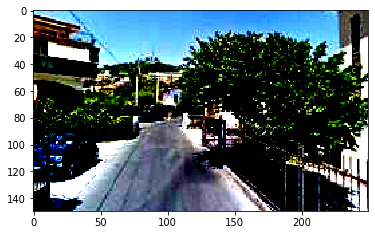

In [20]:
no_aug = no_transforms(image=x[0])['image']
print(no_aug.shape)
plt.imshow(no_aug)

In [21]:
torch.tensor([1,2,3])

tensor([1, 2, 3])

In [22]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        x, y = get_xy(self.paths[idx], MAPPING)
        
        if self.transform:
            x = [transforms(image=img)['image'] for img in x]
        else:
            x = [no_transforms(image=img)['image'] for img in x]
        
        x = torch.tensor([np.rollaxis(img, 2) for img in x])
        
        return x[0], x[1], x[2], x[3], y

In [23]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)

In [24]:
N,E,S,W, y = train_ds[1]
N.shape, y

(torch.Size([3, 150, 250]), 2)

## Model

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.Linear(512 * 4, 128), nn.ReLU(), 
                                        nn.Dropout(), nn.Linear(128, 3))
        self.dropout = nn.Dropout()
        self.bn = nn.BatchNorm1d(512)
        
    def forward(self, N, E, S, W):
        x = [self.features1(img) for img in (N, E, S, W)]
        x = [self.features2(img) for img in x]
        x = [F.relu(img) for img in x]
        x = [nn.AdaptiveAvgPool2d((1,1))(img) for img in x]
        x = [img.view(img.shape[0], -1) for img in x]
        x = torch.cat([self.bn(img) for img in x], axis=1)
        x = self.classifier(self.dropout(x))
        return x

In [26]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for N, E, S, W, y in valid_dl:
        batch = y.shape[0]
        N, E, S, W = N.cuda().float(), E.cuda().float(), S.cuda().float(), W.cuda().float()
        y = y.cuda()
        out = model(N, E, S, W)
        loss = F.cross_entropy(out, y, reduction='sum')
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [27]:
def train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for N, E, S, W, y in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/20, lr/10, lr])
            batch = y.shape[0]
            N, E, S, W = N.cuda().float(), E.cuda().float(), S.cuda().float(), W.cuda().float()
            y = y.cuda()
            out = model(N, E, S, W)
            loss = F.cross_entropy(out, y, reduction='sum')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
            idx += 1
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "data/models/model_resnet18_individ_loss_{0:.0f}.pth".format(100*val_acc)
                save_model(model, path)
                print(path)
    return path

In [28]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [29]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [30]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/100},
              {'params': model.features2.parameters(), 'lr': lr0/10},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-4)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [31]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [32]:
model = Net().cuda()

In [33]:
val_metrics(model, valid_dl)

(1.1312457211812337, 0.335)

In [34]:
best_path = train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=20)

train_loss 1.169 val_loss 1.038 val_acc 0.490
train_loss 1.040 val_loss 0.897 val_acc 0.582
train_loss 0.885 val_loss 0.817 val_acc 0.632
train_loss 0.794 val_loss 0.799 val_acc 0.675
train_loss 0.693 val_loss 0.762 val_acc 0.707
train_loss 0.620 val_loss 0.783 val_acc 0.683
train_loss 0.550 val_loss 0.760 val_acc 0.738
train_loss 0.496 val_loss 0.793 val_acc 0.682


KeyboardInterrupt: 

In [ ]:
#data/models/model_resnet18_stitch_loss_78.pth

## Prediction Evaluation

In [ ]:
best_model = Net().cuda()
load_model(best_model, best_path)

In [ ]:
val.head()

In [ ]:
rev_map = {v: k for k,v in MAPPING.items()}
rev_map

In [ ]:
preds = []
with torch.no_grad():
    best_model.eval()
    for x, y in valid_dl:
        out = best_model(x.cuda().float())
        _, pred = torch.max(out, 1)
        pred = pred.cpu().detach().numpy()
        preds += [rev_map[p] for p in pred]

In [ ]:
val['predictions'] = preds

In [ ]:
val.head()

In [ ]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='predictions')

In [ ]:
(val.Country == val.predictions).sum() / len(val)